# City of Cape Town - Property Valuation Tool
### Sohana Singh

#### Web scraping tool to retrieve property data from Property24

In [1]:
import requests
from bs4 import BeautifulSoup

In [4]:
def get_properties_for_page(page_number):
    page = requests.get("https://www.property24.com/for-sale/cape-town/western-cape/432/p" + str(page_number))
    
    if page.status_code != 200:
        print("Bad status code: " + str(page.status_code))
        exit(1)

    soup = BeautifulSoup(page.text, 'html.parser')

    #remove unwanted characters from the tag
    def extract_value(tag):
        value = None
        if tag is not None:
            value = tag.contents[0].strip().replace('\xa0', '')

        return value
        
    #extracts a property type from a string similar to "1 Bedroom Apartment in Greenpoint" will return "Apartment"
    def extract_property_type_value(tag):
        value = extract_value(tag)
        if value is None:
            return None
        
        start_index = 0
        end_index = len(value)
        
        bedroom_index = value.find("Bedroom")
        
        if bedroom_index > -1:
            start_index = bedroom_index + 8
            
        in_index = value.find("For Sale")
        if in_index > -1:
            end_index = in_index - 1
        else:  
            in_index = value.find("in")
            if in_index > -1:
                end_index = in_index - 1
            
        return value[start_index:end_index]
        

    def get_properties(tag):
        properties = []
        for x in tag:
            id = x['data-listing-number']
            price = None
            price_tag = x.find(class_='p24_price')
            d = price_tag.attrs
            if "content" in d:
                price = price_tag['content']
            else:
                price = extract_value(x.find(class_='p24_price'))
            location = extract_value(x.find(class_='p24_location'))
            address = extract_value(x.find(class_='p24_address'))
            property_type = extract_property_type_value(x.find(class_='p24_description'))
            if property_type is None:
                property_type = extract_property_type_value(x.find(class_='p24_title'))
                
            size_tag = x.find(class_='p24_size')
            size = None
            if size_tag is not None:
                size = extract_value(size_tag.contents[3])
            features = x.find_all(class_='p24_featureDetails')
            p = {
                'id': id,
                'price': price,
                'location': location,
                'address': address,
                'size': size,
                'property_type': property_type
            }
            for f in features:
                feature_name = f['title']
                feature_value = f.span.contents[0]
                p[feature_name] = feature_value

            properties.append(p)
        return properties

    promoted = get_properties(soup.find_all(class_='p24_promotedTile'))
    regular = get_properties(soup.find_all(class_='p24_regularTile'))

    return promoted + regular

all_properties = []

for i in range(1, 451): #getting one page of properties, adjust to get more pages
    print(i)
    all_properties.extend(get_properties_for_page(i))

print(len(all_properties))
print(all_properties[0])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


#### Save the object as json file

In [7]:
import json


In [6]:
#with open('capetown_2022.txt', 'w') as json_file:
  #json.dump(all_properties, json_file)

#### Importing packages to use for modelling section

In [8]:
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize #package for flattening json in pandas df

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

%matplotlib inline

In [9]:
#load json object
with open('ct_prop3.txt') as f:
    d = json.load(f)

In [10]:
d

[{'id': 'P108907258',
  'price': 'R 1265000',
  'location': 'Muizenberg',
  'address': None,
  'size': '61 m²',
  'property_type': 'Apartment',
  'Bedrooms': '1',
  'Bathrooms': '1',
  'Parking Spaces': '1'},
 {'id': 'P107995966',
  'price': 'R 4950000',
  'location': 'Constantia',
  'address': '7 Chantecler Ln',
  'size': '2 448 m²',
  'property_type': 'Vacant Land'},
 {'id': 'P109087490',
  'price': 'R 1385000',
  'location': 'Vredehoek',
  'address': '36 Clifford Ave',
  'size': '51 m²',
  'property_type': 'Apartment',
  'Bedrooms': '1',
  'Bathrooms': '1',
  'Parking Spaces': '1'},
 {'id': 'P109136653',
  'price': 'R 9900000',
  'location': 'Oranjezicht',
  'address': '7 Breda Street',
  'size': '677 m²',
  'property_type': 'House',
  'Bedrooms': '6',
  'Bathrooms': '3',
  'Parking Spaces': '8'},
 {'id': 'P108792479',
  'price': 'R 9900000',
  'location': 'Oranjezicht',
  'address': '7 Breda Street',
  'size': '677 m²',
  'property_type': 'Commercial Property'},
 {'id': 'P108865315

In [11]:
ct = pd.json_normalize(data=d) # get data into pandas dataframe

In [12]:
ct.head()

,id,price,location,address,size,property_type,Bedrooms,Bathrooms,Parking Spaces
0,P108907258,R 1265000,Muizenberg,None,61 m²,Apartment,1,1,1
1,P107995966,R 4950000,Constantia,7 Chantecler Ln,2 448 m²,Vacant Land,NaN,NaN,NaN
2,P109087490,R 1385000,Vredehoek,36 Clifford Ave,51 m²,Apartment,1,1,1
3,P109136653,R 9900000,Oranjezicht,7 Breda Street,677 m²,House,6,3,8
4,P108792479,R 9900000,Oranjezicht,7 Breda Street,677 m²,Commercial Property,NaN,NaN,NaN


In [13]:
#Removing vacant land, commercial and industrial properties
ct.drop(ct.index[ct['property_type'] == 'Vacant Land'], inplace = True)
ct.drop(ct.index[ct['property_type'] == 'Commercial Property'], inplace = True)
ct.drop(ct.index[ct['property_type'] == 'Industrial Property'], inplace = True)
ct.drop(ct.index[ct['property_type'] == 'Farm'], inplace = True)

In [14]:
ct['price'] = ct['price'].str.replace(r"[a-zA-Z]",'')

In [15]:
ct['size'] = ct['size'].str.replace(r'\D', '')

In [16]:
ct.head()

,id,price,location,address,size,property_type,Bedrooms,Bathrooms,Parking Spaces
0,P108907258,1265000,Muizenberg,None,61,Apartment,1,1,1
2,P109087490,1385000,Vredehoek,36 Clifford Ave,51,Apartment,1,1,1
3,P109136653,9900000,Oranjezicht,7 Breda Street,677,House,6,3,8
6,P108859219,6480000,Tokai,None,304,House,3,3,2
7,P108909566,28000000,Waterfront,None,192,Apartment,3,3,2


In [17]:
#convert to numeric
ct['price'] = pd.to_numeric(ct['price'])
ct['size'] = pd.to_numeric(ct['size'])
ct['Bedrooms'] = pd.to_numeric(ct['Bedrooms'])
ct['Bathrooms'] = pd.to_numeric(ct['Bathrooms'])
ct['Parking Spaces'] = pd.to_numeric(ct['Parking Spaces'])

In [18]:
ct.dtypes

id                 object
price             float64
location           object
address            object
size              float64
property_type      object
Bedrooms          float64
Bathrooms         float64
Parking Spaces    float64
dtype: object

In [19]:
ct.count() # show us the number of rows

id                8326
price             8267
location          8326
address           3662
size              7739
property_type     8326
Bedrooms          8079
Bathrooms         8220
Parking Spaces    6738
dtype: int64

In [20]:
ct.describe() # Taking a look at some descriptive statistics

,price,size,Bedrooms,Bathrooms,Parking Spaces
count,8.267000e+03,7.739000e+03,8079.000000,8220.000000,6738.000000
mean,5.701456e+06,5.932537e+03,2.613937,2.058759,2.166741
std,8.339741e+06,4.887912e+05,1.625720,1.437450,1.918130
min,1.990000e+05,1.700000e+01,0.500000,0.500000,1.000000
25%,1.850000e+06,6.700000e+01,2.000000,1.000000,1.000000
50%,2.995000e+06,1.180000e+02,2.000000,2.000000,2.000000
75%,5.995000e+06,3.950000e+02,3.000000,2.500000,2.000000
max,2.000000e+08,4.300000e+07,33.000000,30.000000,58.000000


In [21]:
ct.groupby(['Bedrooms'])['size'].median()

Bedrooms
0.5       39.0
1.0       54.5
1.5      109.0
2.0       89.0
2.5      200.0
3.0      257.5
3.5      239.0
4.0      599.5
4.5      414.0
5.0      817.0
6.0      692.5
7.0      966.0
8.0      728.0
9.0      833.0
10.0     986.0
11.0     633.0
12.0     467.5
13.0     485.0
14.0     929.0
15.0    1212.5
16.0     929.0
18.0     235.0
21.0       NaN
30.0    2800.0
33.0    1930.0
Name: size, dtype: float64

In [22]:
ct.groupby(['Bedrooms'])['price'].median()

Bedrooms
0.5      1590000.0
1.0      1897499.5
1.5      2647500.0
2.0      2750000.0
2.5      2772500.0
3.0      3950000.0
3.5      3375000.0
4.0      7900000.0
4.5     59950000.0
5.0      8925000.0
6.0      8997500.0
7.0      8450000.0
8.0      6175000.0
9.0     12300000.0
10.0     5650000.0
11.0     9600000.0
12.0    19500000.0
13.0    10697500.0
14.0     9900000.0
15.0    29900000.0
16.0     9900000.0
18.0     8495000.0
21.0           NaN
30.0    64700000.0
33.0    25000000.0
Name: price, dtype: float64

In [23]:
ct.groupby(['Bathrooms'])['price'].median()

Bathrooms
0.5      1770000.0
1.0      1808900.0
1.5      2595000.0
2.0      3597500.0
2.5      6750000.0
3.0      6900000.0
3.5     11500000.0
4.0     10950000.0
4.5     15650000.0
5.0     12500000.0
5.5     21972500.0
6.0     12075000.0
6.5     22325000.0
7.0     18900000.0
7.5     24625000.0
8.0     15999000.0
8.5     44000000.0
9.0     15995000.0
9.5     66500000.0
10.0    21000000.0
11.0    25000000.0
12.0    12100000.0
13.0    19500000.0
14.0    10297500.0
15.0    21000000.0
16.0    19900000.0
18.0    19500000.0
25.0     4075000.0
30.0    64700000.0
Name: price, dtype: float64

In [24]:
ct.groupby(['Parking Spaces'])['price'].median()

Parking Spaces
1.0      2250000.0
1.5       980000.0
2.0      4950000.0
3.0      5850000.0
4.0      6700000.0
5.0      4500000.0
6.0      8497500.0
7.0      5897500.0
8.0      9900000.0
9.0     15495497.5
10.0     8995000.0
11.0     7850000.0
12.0    10900000.0
13.0    21000000.0
14.0     8000000.0
15.0    21850000.0
20.0    23500000.0
22.0     3900000.0
58.0     1999999.0
Name: price, dtype: float64

In [25]:
ct.groupby(['size'])['price'].mean()

size
17.0          8.950000e+05
20.0          7.166930e+05
21.0          8.950000e+05
22.0          6.225000e+05
24.0          7.758878e+05
                  ...     
14000.0       4.500000e+07
16199.0       6.900000e+06
39423.0       1.999900e+07
43000.0       7.000000e+06
43000000.0    2.000000e+08
Name: price, Length: 1182, dtype: float64

In [26]:
ct.isnull().sum()

id                   0
price               59
location             0
address           4664
size               587
property_type        0
Bedrooms           247
Bathrooms          106
Parking Spaces    1588
dtype: int64

In [27]:
ct['price'] = ct['price'].fillna(ct.groupby('size')['price'].transform('mean'))

In [28]:
ct['size'] = ct['size'].fillna(ct.groupby('price')['size'].transform('mean'))

In [29]:
ct['Bedrooms'] = ct['Bedrooms'].fillna(ct.groupby('price')['Bedrooms'].transform('median'))

In [30]:
ct['Bathrooms'] = ct['Bathrooms'].fillna(ct.groupby('price')['Bathrooms'].transform('median'))

In [31]:
ct['Parking Spaces'] = ct['Parking Spaces'].fillna(ct.groupby('price')['Parking Spaces'].transform('median'))

In [32]:
ct.isnull().sum()

id                   0
price               16
location             0
address           4664
size                85
property_type        0
Bedrooms            32
Bathrooms           13
Parking Spaces     158
dtype: int64

In [33]:
ct['price'].fillna((ct['price'].mean()), inplace=True)

In [34]:
ct.isnull().sum()

id                   0
price                0
location             0
address           4664
size                85
property_type        0
Bedrooms            32
Bathrooms           13
Parking Spaces     158
dtype: int64

In [35]:
ct['size'] = ct['size'].fillna(ct.groupby('price')['size'].transform('mean'))

In [36]:
ct['size'].fillna((ct['size'].mean()), inplace=True)

In [37]:
ct['Bedrooms'] = ct['Bedrooms'].fillna(ct.groupby('price')['Bedrooms'].transform('median'))

In [38]:
ct['Bathrooms'] = ct['Bathrooms'].fillna(ct.groupby('price')['Bathrooms'].transform('median'))

In [39]:
ct['Parking Spaces'] = ct['Parking Spaces'].fillna(ct.groupby('price')['Parking Spaces'].transform('median'))

In [40]:
ct['Bedrooms'].fillna((ct['Bedrooms'].median()), inplace=True)

In [41]:
ct['Bathrooms'].fillna((ct['Bathrooms'].median()), inplace=True)

In [42]:
ct['Parking Spaces'].fillna((ct['Parking Spaces'].median()), inplace=True)

In [43]:
ct.isnull().sum()

id                   0
price                0
location             0
address           4664
size                 0
property_type        0
Bedrooms             0
Bathrooms            0
Parking Spaces       0
dtype: int64

### Visualizing Data & Exploratory Analyses

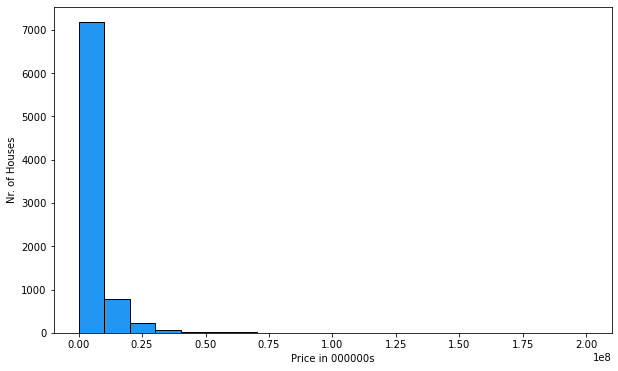

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(ct['price'], bins=20, ec='black', color='#2196f3')
plt.xlabel('Price in 000000s')
plt.ylabel('Nr. of Houses')
plt.show()

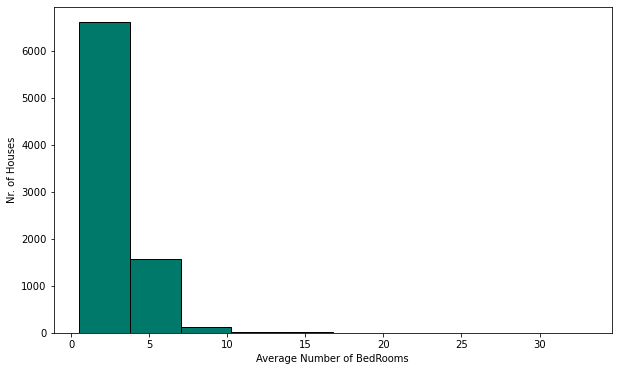

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(ct['Bedrooms'], ec='black', color='#00796b')
plt.xlabel('Average Number of BedRooms')
plt.ylabel('Nr. of Houses')
plt.show()

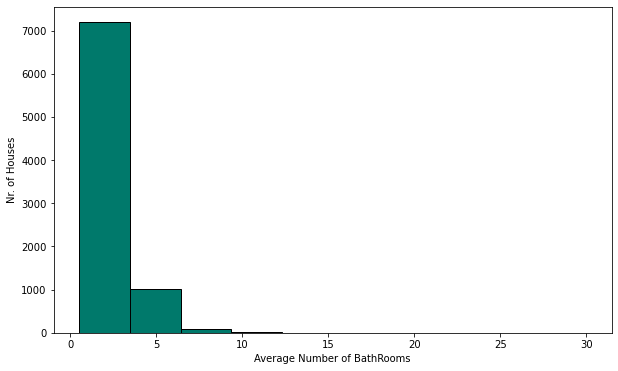

In [46]:
plt.figure(figsize=(10, 6))
plt.hist(ct['Bathrooms'], ec='black', color='#00796b')
plt.xlabel('Average Number of BathRooms')
plt.ylabel('Nr. of Houses')
plt.show()

In [47]:
ct.corr()

,price,size,Bedrooms,Bathrooms,Parking Spaces
price,1.000000,0.256401,0.420218,0.572941,0.330499
size,0.256401,1.000000,-0.003191,0.000362,-0.002446
Bedrooms,0.420218,-0.003191,1.000000,0.794752,0.510240
Bathrooms,0.572941,0.000362,0.794752,1.000000,0.486953
Parking Spaces,0.330499,-0.002446,0.510240,0.486953,1.000000


In [48]:
mask = np.zeros_like(ct.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True
mask

array([[1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.]])

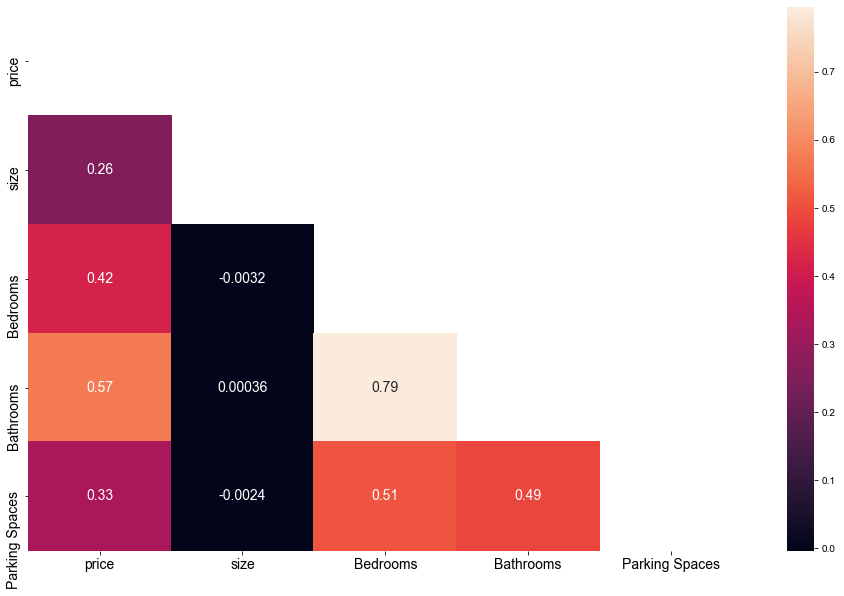

In [49]:
plt.figure(figsize=(16,10))
sns.heatmap(ct.corr(), mask=mask, annot=True, annot_kws={"size": 14})
sns.set_style('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Encoding categorical features such as location and property type

In [50]:
ct["location"].value_counts()

Sea Point                796
Cape Town City Centre    725
Green Point              376
Woodstock                329
Constantia               294
                        ... 
Nooitgedacht               1
Ndabeni                    1
High Constantia            1
Kewtown                    1
Windermere                 1
Name: location, Length: 146, dtype: int64

In [51]:
ct["property_type"].value_counts()

Apartment    4863
House        3163
Townhouse     300
Name: property_type, dtype: int64

In [52]:
ct_en = pd.get_dummies(ct, columns=["location", "property_type"], drop_first=True)

In [53]:
ct_en

,id,price,address,size,Bedrooms,Bathrooms,Parking Spaces,location_Athlone,location_Bakoven,location_Bantry Bay,...,location_Wetton,location_Windermere,location_Woodstock,location_Wynberg,location_Wynberg Upper,location_Zeekoevlei,location_Zonnebloem,location_Zwaanswyk,property_type_House,property_type_Townhouse
0,P108907258,1265000.0,None,61.0,1.0,1.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,P109087490,1385000.0,36 Clifford Ave,51.0,1.0,1.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,P109136653,9900000.0,7 Breda Street,677.0,6.0,3.0,8.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,P108859219,6480000.0,None,304.0,3.0,3.0,2.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,P108909566,28000000.0,None,192.0,3.0,3.0,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9215,106337080,8500000.0,None,225.0,2.0,2.0,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9220,109030721,2100000.0,None,1100.0,4.0,2.0,12.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9225,109120907,2799000.0,19 Coventry Road,116.0,3.0,2.0,1.5,0,0,0,...,0,0,1,0,0,0,0,0,1,0
9226,109072910,3600000.0,None,60.0,1.0,1.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [54]:
ct_en.corr()

,price,size,Bedrooms,Bathrooms,Parking Spaces,location_Athlone,location_Bakoven,location_Bantry Bay,location_Barbarosa Estate,location_Bel Ombre,...,location_Wetton,location_Windermere,location_Woodstock,location_Wynberg,location_Wynberg Upper,location_Zeekoevlei,location_Zonnebloem,location_Zwaanswyk,property_type_House,property_type_Townhouse
price,1.000000,0.256401,0.420218,0.572941,0.330499,-0.014602,0.091030,0.190888,0.002481,0.022877,...,-0.010935,-0.006399,-0.085018,-0.053978,-0.042210,-0.014854,-0.058733,0.048295,0.235021,-0.013374
size,0.256401,1.000000,-0.003191,0.000362,-0.002446,-0.000398,-0.000437,-0.001291,-0.000075,-0.000006,...,-0.000314,-0.000128,-0.002330,-0.001107,-0.001335,-0.000422,-0.001483,-0.000178,0.014698,-0.002184
Bedrooms,0.420218,-0.003191,1.000000,0.794752,0.510240,0.037861,0.038579,0.018765,0.009556,0.013515,...,0.007821,0.002764,-0.045896,-0.030139,-0.017593,0.038250,-0.054695,0.043906,0.597569,0.031382
Bathrooms,0.572941,0.000362,0.794752,1.000000,0.486953,0.012404,0.063946,0.056655,-0.000431,0.010200,...,-0.002573,-0.008075,-0.084946,-0.046950,-0.019168,0.002686,-0.075742,0.038220,0.438723,0.035086
Parking Spaces,0.330499,-0.002446,0.510240,0.486953,1.000000,0.013558,0.003744,-0.000976,-0.000115,0.043399,...,0.014928,-0.006275,-0.083381,-0.040123,-0.015142,0.059428,-0.065371,0.067122,0.442868,-0.011079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
location_Zeekoevlei,-0.014854,-0.000422,0.038250,0.002686,0.059428,-0.001438,-0.001891,-0.004762,-0.000433,-0.000613,...,-0.001226,-0.000433,-0.008021,-0.003968,-0.004782,1.000000,-0.005019,-0.001564,0.050524,-0.007645
location_Zonnebloem,-0.058733,-0.001483,-0.054695,-0.075742,-0.065371,-0.004616,-0.006070,-0.015283,-0.001391,-0.001967,...,-0.003936,-0.001391,-0.025744,-0.012736,-0.015348,-0.005019,1.000000,-0.005019,-0.069627,-0.014220
location_Zwaanswyk,0.048295,-0.000178,0.043906,0.038220,0.067122,-0.001438,-0.001891,-0.004762,-0.000433,-0.000613,...,-0.001226,-0.000433,-0.008021,-0.003968,-0.004782,-0.001564,-0.005019,1.000000,0.044256,-0.007645
property_type_House,0.235021,0.014698,0.597569,0.438723,0.442868,0.046469,0.009242,-0.033790,0.014003,0.019804,...,0.023648,0.014003,0.020342,-0.026232,-0.007448,0.050524,-0.069627,0.044256,1.000000,-0.151325


In [55]:
X = ct_en.drop(columns = ['address'])

In [56]:
X

,id,price,size,Bedrooms,Bathrooms,Parking Spaces,location_Athlone,location_Bakoven,location_Bantry Bay,location_Barbarosa Estate,...,location_Wetton,location_Windermere,location_Woodstock,location_Wynberg,location_Wynberg Upper,location_Zeekoevlei,location_Zonnebloem,location_Zwaanswyk,property_type_House,property_type_Townhouse
0,P108907258,1265000.0,61.0,1.0,1.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,P109087490,1385000.0,51.0,1.0,1.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,P109136653,9900000.0,677.0,6.0,3.0,8.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,P108859219,6480000.0,304.0,3.0,3.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,P108909566,28000000.0,192.0,3.0,3.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9215,106337080,8500000.0,225.0,2.0,2.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9220,109030721,2100000.0,1100.0,4.0,2.0,12.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9225,109120907,2799000.0,116.0,3.0,2.0,1.5,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
9226,109072910,3600000.0,60.0,1.0,1.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Standardizing the data

In [57]:
X['price'].skew()

6.558462985593459

<AxesSubplot:xlabel='price'>

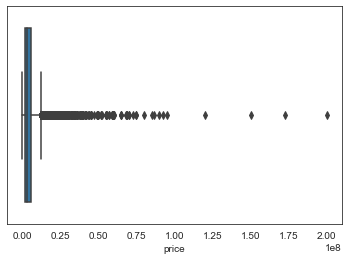

In [58]:
sns.boxplot(x=X['price'])

In [59]:
X.describe()

,price,size,Bedrooms,Bathrooms,Parking Spaces,location_Athlone,location_Bakoven,location_Bantry Bay,location_Barbarosa Estate,location_Bel Ombre,...,location_Wetton,location_Windermere,location_Woodstock,location_Wynberg,location_Wynberg Upper,location_Zeekoevlei,location_Zonnebloem,location_Zwaanswyk,property_type_House,property_type_Townhouse
count,8.326000e+03,8.326000e+03,8326.000000,8326.000000,8326.000000,8326.000000,8326.000000,8326.000000,8326.000000,8326.000000,...,8326.000000,8326.000000,8326.000000,8326.000000,8326.000000,8326.000000,8326.000000,8326.000000,8326.000000,8326.000000
mean,5.710395e+06,5.587270e+03,2.593082,2.056450,2.018616,0.001321,0.002282,0.014293,0.000120,0.000240,...,0.000961,0.000120,0.039515,0.009969,0.014413,0.001561,0.015854,0.001561,0.379894,0.036032
std,8.327336e+06,4.712457e+05,1.613694,1.433987,1.779264,0.036326,0.047719,0.118701,0.010959,0.015498,...,0.030984,0.010959,0.194828,0.099351,0.119192,0.039486,0.124918,0.039486,0.485389,0.186380
min,1.990000e+05,1.700000e+01,0.500000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.850000e+06,6.900000e+01,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.995000e+06,1.220000e+02,2.000000,2.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.995000e+06,3.957500e+02,3.000000,2.500000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2.000000e+08,4.300000e+07,33.000000,30.000000,58.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Function to get rid of outliers

In [60]:
def get_outliers(X, outliers_fraction=0.25):
    clf = svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05, kernel="rbf", gamma=0.1)
    clf.fit(X)
    result = clf.predict(X)
    return result

In [61]:
x5 = X[get_outliers(X.drop(columns=['id']), 0.15)==1]

In [62]:
x5.describe()

,price,size,Bedrooms,Bathrooms,Parking Spaces,location_Athlone,location_Bakoven,location_Bantry Bay,location_Barbarosa Estate,location_Bel Ombre,...,location_Wetton,location_Windermere,location_Woodstock,location_Wynberg,location_Wynberg Upper,location_Zeekoevlei,location_Zonnebloem,location_Zwaanswyk,property_type_House,property_type_Townhouse
count,3.938000e+03,3938.000000,3938.000000,3938.000000,3938.000000,3938.000000,3938.000000,3938.000000,3938.0,3938.000000,...,3938.000000,3938.0,3938.000000,3938.000000,3938.000000,3938.000000,3938.000000,3938.000000,3938.000000,3938.000000
mean,5.382240e+06,413.799561,2.510030,1.984192,1.954418,0.000762,0.001524,0.014728,0.0,0.000508,...,0.001524,0.0,0.040376,0.008380,0.015998,0.001016,0.017776,0.001270,0.360843,0.036567
std,7.686497e+06,1018.452561,1.611085,1.426448,1.638963,0.027594,0.039009,0.120478,0.0,0.022533,...,0.039009,0.0,0.196864,0.091169,0.125483,0.031859,0.132151,0.035614,0.480306,0.187719
min,3.000000e+05,20.000000,0.500000,0.500000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.790000e+06,66.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.800000e+06,109.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.500000e+06,353.250000,3.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.500000e+08,16199.000000,33.000000,30.000000,22.000000,1.000000,1.000000,1.000000,0.0,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
x5

,id,price,size,Bedrooms,Bathrooms,Parking Spaces,location_Athlone,location_Bakoven,location_Bantry Bay,location_Barbarosa Estate,...,location_Wetton,location_Windermere,location_Woodstock,location_Wynberg,location_Wynberg Upper,location_Zeekoevlei,location_Zonnebloem,location_Zwaanswyk,property_type_House,property_type_Townhouse
19,109154455,1050000.0,56.800000,2.0,1.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,109154270,4850000.0,252.000000,4.0,4.5,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
27,109154145,690000.0,84.000000,3.0,1.0,6.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
29,109153982,3500000.0,86.000000,2.0,1.0,1.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
32,109153799,1500000.0,86.151515,2.0,1.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9186,108630210,2900000.0,217.153846,4.0,1.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9188,106787438,5950000.0,189.000000,2.0,2.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9208,107367980,28650000.0,1827.000000,4.0,4.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9209,107980205,3500000.0,140.000000,2.0,2.0,1.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Linear Regression

In [65]:
prices = np.log(x5['price']) # Use log prices
features = x5.drop(columns = ['price', 'id'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, prices, 
                                                    test_size=0.2, random_state=10)

regr = LinearRegression()
regr.fit(X_train, y_train)

print('Training data r-squared:', regr.score(X_train, y_train))
print('Test data r-squared:', regr.score(X_test, y_test))

print('Intercept', regr.intercept_)
pd.DataFrame(data=regr.coef_, index=X_train.columns, columns=['coef'])

Training data r-squared: 0.7876716360290389
Test data r-squared: 0.7706414381780496
Intercept 12.851868891533382


,coef
size,0.000033
Bedrooms,0.053199
Bathrooms,0.154364
Parking Spaces,0.051061
location_Athlone,0.584674
...,...
location_Zeekoevlei,0.933673
location_Zonnebloem,1.178615
location_Zwaanswyk,2.233390
property_type_House,0.380415


### Trying to find the best model

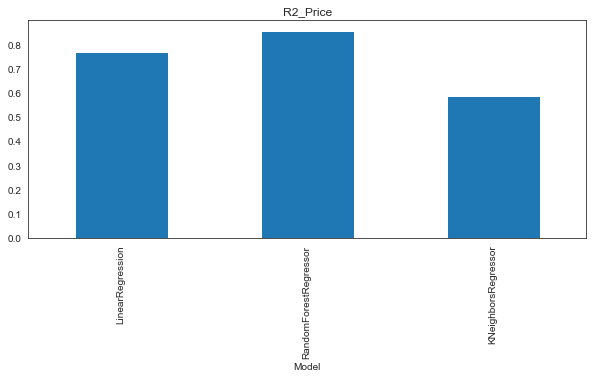

In [66]:
    models = [LinearRegression(),
              RandomForestRegressor(n_estimators=100, max_features='sqrt'),
              KNeighborsRegressor(n_neighbors=6)]
 
    TestModels = pd.DataFrame()
    tmp = {}
 
    for model in models:
        # get model name
        m = str(model)
        tmp['Model'] = m[:m.index('(')]
        # fit model on training dataset
        model.fit(X_train, y_train)
        # predict prices for test dataset and calculate r^2
        tmp['R2_Price'] = r2_score(y_test, model.predict(X_test))
        # write obtained data
        TestModels = TestModels.append([tmp])
 
    TestModels.set_index('Model', inplace=True)
 
    fig, axes = plt.subplots(ncols=1, figsize=(10, 4))
    TestModels.R2_Price.plot(ax=axes, kind='bar', title='R2_Price')
    plt.show()

The best model seems to be the random forest regressor

In [67]:
regr2 = RandomForestRegressor(n_estimators=300, max_features='sqrt')
results = regr2.fit(X_train, y_train)

print('Training data r-squared:', regr2.score(X_train, y_train))
print('Test data r-squared:', regr2.score(X_test, y_test))

#print('Intercept', regr2.intercept_)
#pd.DataFrame(data=regr2.coef_, index=X_train.columns, columns=['coef'])

Training data r-squared: 0.9751138205251816
Test data r-squared: 0.8548099667335418


In [68]:
# Predicting the Test set results
y_pred = regr2.predict(X_test)

In [69]:
# Evaluating the Algorithm
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.23879064678310372
Mean Squared Error: 0.1201723344772253
Root Mean Squared Error: 0.346658815663507


In [70]:
model_RF = RandomForestRegressor(n_estimators=300, max_features='sqrt').fit(features, prices)
fitted_vals = model_RF.predict(features)
MSE = mean_squared_error(prices, fitted_vals)
RMSE = np.sqrt(MSE)


In [71]:
feature_list = list(features.columns)
# Get numerical feature importances
importances = list(model_RF.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Bathrooms            Importance: 0.24
Variable: size                 Importance: 0.21
Variable: Parking Spaces       Importance: 0.11
Variable: Bedrooms             Importance: 0.09
Variable: location_Camps Bay   Importance: 0.03
Variable: property_type_House  Importance: 0.03
Variable: location_Bantry Bay  Importance: 0.02
Variable: location_Constantia  Importance: 0.02
Variable: location_Fresnaye    Importance: 0.02
Variable: location_Clifton     Importance: 0.01
Variable: location_De Waterkant Importance: 0.01
Variable: location_Green Point Importance: 0.01
Variable: location_Llandudno   Importance: 0.01
Variable: location_Maitland    Importance: 0.01
Variable: location_Mouille Point Importance: 0.01
Variable: location_Muizenberg  Importance: 0.01
Variable: location_Pelican Park Importance: 0.01
Variable: location_Sea Point   Importance: 0.01
Variable: location_Waterfront  Importance: 0.01
Variable: location_Wynberg     Importance: 0.01
Variable: location_Athlone     Impor

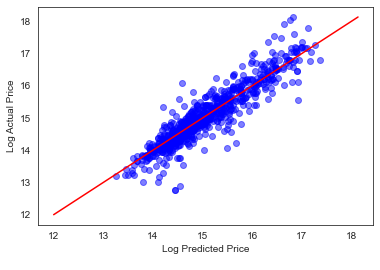

In [72]:
actual_values = y_test
plt.scatter(y_pred, actual_values, alpha=.5,
            color='b')
plt.xlabel('Log Predicted Price')
plt.ylabel('Log Actual Price')
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    model_RF.score(X_test, y_test),
                    mean_squared_error(y_test, y_pred))
plt.annotate(text=overlay,xy=(12.1,10.6),size='x-large')
# Now add the perfect prediction line
diagonal = np.linspace(12, np.max(y_test), 100)
plt.plot(diagonal, diagonal, '-r')
plt.show()

In [73]:
features.mean()

size                       413.799561
Bedrooms                     2.510030
Bathrooms                    1.984192
Parking Spaces               1.954418
location_Athlone             0.000762
                              ...    
location_Zeekoevlei          0.001016
location_Zonnebloem          0.017776
location_Zwaanswyk           0.001270
property_type_House          0.360843
property_type_Townhouse      0.036567
Length: 151, dtype: float64

In [74]:
property_stats = features.mean().values.reshape(1, 151)

In [75]:
property_stats[0][0]

413.7995605763766

In [76]:
def get_log_estimate(size,
                    bed,
                    bath,
                    parking,
                    high_confidence=True):
    
    # Configure property
    property_stats[0][0] = size
    property_stats[0][1] = bed
    property_stats[0][2] = bath
    property_stats[0][3] = parking
   
    # Make prediction
    log_estimate = model_RF.predict(property_stats)[0]
    
    # Calc Range 
    if high_confidence:
        upper_bound = log_estimate + 2*RMSE
        lower_bound = log_estimate - 2*RMSE
        interval = 95
    else:
        upper_bound = log_estimate + RMSE
        lower_bound = log_estimate - RMSE
        interval = 68
    
    return log_estimate, upper_bound, lower_bound, interval

In [77]:
get_log_estimate(size = 100, bed = 2, bath = 1, parking = 1, high_confidence = True)

(14.603872379168257, 14.873710203236223, 14.33403455510029, 95)

In [78]:
def get_estimate(size, bath, bed, parking, high_confidence = False):
    """Estimate the price of a property in Cape Town.
    
    Keyword arguments:
    size -- size of property
    bath -- number of bathrooms in the property.
    bed -- number of bedrooms in the property
    park -- number of parking spaces on the property
    large_range -- True for a 95% prediction interval, False for a 68% interval.
    
    """
    
    
    if size < 10 or bath < 1 or bed < 1:
        print('That is unrealistic. Try again.')
        return

    log_est, upper, lower, conf = get_log_estimate(size, 
                                                   bed, 
                                                   bath,
                                                   parking,
                                                   high_confidence)

    # Convert log to Rands
    rand_est = np.e**log_est 
    rand_hi = np.e**upper 
    rand_low = np.e**lower

    # Round the dollar values to nearest thousand
    rounded_est = np.around(rand_est, -3)
    rounded_hi = np.around(rand_hi, -3)
    rounded_low = np.around(rand_low, -3)

    return rounded_est, rounded_hi, rounded_low, conf
    #print(f'The estimated property value is {rounded_est}.')
    #print(f'At {conf}% confidence the valuation range is')
    #print(f'Rands {rounded_low} at the lower end to Rands {rounded_hi} at the high end.')

In [79]:
get_estimate(size=400, bed = 3, bath = 2, parking = 2, high_confidence = True)

(6838000.0, 8956000.0, 5221000.0, 95)

In [80]:
from flask import Flask, request, jsonify, url_for, render_template
import uuid
import os

In [81]:
app = Flask(__name__)
#model = MobileNet(weights='imagenet', include_top=True)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/prediction')
def predict():
    size = int(request.args.get('size'))
    bed = int(request.args.get('bed'))
    bath = int(request.args.get('bath'))
    parking = int(request.args.get('parking'))
    rounded_est, rounded_hi, rounded_low, conf = get_estimate(size = size, bed = bed, bath = bath, parking = parking, high_confidence = True)
    return render_template('prediction.html', prediction = f'The estimated property value is R{rounded_est}, At {conf}% confidence the valuation range is R{rounded_low} at the lower end to R{rounded_hi} at the high end.')

if __name__ == '__main__':
    app.run(debug=True, use_reloader=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [24/Sep/2020 22:25:41] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/Sep/2020 22:25:41] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [24/Sep/2020 22:26:01] "GET /prediction?size=100&bed=1&bath=1&parking=1&submit=Submit HTTP/1.1" 200 -
